# Implémentation algorithme k-NN

Dans ce projet, nous allons nous intéresser à l'implémentation de l'algorithme k-NN. 
De plus, en calculant la justesse de prédiction et le temps d'exécution de notre algorithme créé précédemment, nous allons les comparer avec ceux qu'on obtient en travaillant avec la bibliothéque sckit learn. 

In [1]:
from sklearn import datasets
import pandas as pd
import timeit
from math import sqrt, ceil
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Datasets

Nous allons voir quels sont les jeux de données avec lesquels nous avons travaillé.  Nous avons utilisé trois jeux de données différents : 2 qui sont des données standard de python et un jeu de données réel toujours de python. 

### Iris Dataset (Toy Dataset)

Ce jeu de données contient 4 colonnes donnant la largeur et longueur des pétales et sépales de différentes iris. 
Nous allons travailler sur deux colonnes : 
- **Petal length** : Longueur de la pétale 
- **Petal width** : Largeur de la pétale 

Target (type d'iris) : 
- Setosa
- Versicolor 
- Virginica

In [2]:
iris = datasets.load_iris()
iris_corr = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_corr.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [3]:
iris_data = iris.data[:, [2, 3]].tolist()
iris_target = iris.target

df_iris = pd.DataFrame(iris_data)
df_iris.describe()

,0,1
count,150.000000,150.000000
mean,3.758000,1.199333
std,1.765298,0.762238
min,1.000000,0.100000
25%,1.600000,0.300000
50%,4.350000,1.300000
75%,5.100000,1.800000
max,6.900000,2.500000


### Wine Dataset (Toy Dataset)

Ce jeu de données contient 13 colonnes pour les 13 analyses différentes faite sur différents vins provenant d'un même secteur en Italie. 

Nous allons travailler sur deux colonnes : 
- **Flavonoïde** : Pigmentation responsable de la coloration du vin 
- **Total_phenols** : Groupe de composés chimiques qui affectent la couleur

Target (en fonction de quel vignerons provient le vin) : 
- Class 1
- Class 2 
- Class 3 

In [4]:
wine = datasets.load_wine()
wine_corr = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_corr.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


In [5]:
wine_data = wine.data[:, :2].tolist()
wine_target = wine.target
wine_data_len = len(wine_data)

df_wine = pd.DataFrame(wine_data)
df_wine.describe()

,0,1
count,178.000000,178.000000
mean,13.000618,2.336348
std,0.811827,1.117146
min,11.030000,0.740000
25%,12.362500,1.602500
50%,13.050000,1.865000
75%,13.677500,3.082500
max,14.830000,5.800000


### Forest Covertypes Dataset (Real World Dataset)

Ce dernier jeu de données concerne les couvertures forestières, c’est-à-dire les superficies des terres couvertes par la forêt, aux Etats-Unis. Il contient 13 variables dont 3 qui sont développées en plusieurs colonnes c’est pour cela qu’il y a plus de 13 colonnes. 

Nous allons travailler sur deux colonnes : 
- **Horizontal_Distance_To_Hydrology**: La distance en horizontal entre la plateforme où y a les arbres et la plateforme où y a de l'eau
- **Vertical_Distance_To_Hydrology**: La distance en vertical entre la plateforme où y a les arbres et la plateforme où y a de l'eau

Target (type de couverture forestière):
- 1: Spruce/Fir
- 2: Lodgepole Pine
- 3: Ponderosa Pine
- 4: Cottonwood/Willow
- 5: Aspen
- 6: Douglas-fir
- 7: Krummholz

In [6]:
forest = datasets.fetch_covtype()
forest_corr = pd.DataFrame(forest.data)
forest_corr.corr()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,...,0.070405,0.167077,0.070633,0.011731,0.083005,0.021107,0.035433,0.217179,0.193595,0.212612
1,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,...,0.001763,0.056233,0.019163,0.010861,-0.021991,0.002281,-0.020398,0.017706,0.008294,-0.005866
2,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,...,-0.034610,-0.133504,0.208942,-0.011002,-0.022228,0.002918,0.007848,-0.072208,0.093602,0.025637
3,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,...,0.073658,0.127217,0.101195,0.070268,-0.005231,0.033421,-0.006802,0.043031,0.031922,0.147020
4,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,...,0.033609,0.039762,0.167091,0.060274,-0.006092,0.012955,-0.007520,-0.008629,0.043859,0.179006
5,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,...,-0.058840,-0.089019,-0.082779,0.006390,-0.003000,0.007550,0.016313,0.079778,0.033762,0.016052
6,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,...,-0.035114,0.006494,-0.064381,0.007154,0.027870,0.007865,0.010332,0.015108,-0.029620,-0.000016
7,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,...,-0.000095,0.125395,-0.086164,0.043061,0.005863,0.016239,-0.022707,0.042952,-0.071961,-0.040176
8,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,...,0.040475,0.083066,-0.024393,0.017757,-0.016482,0.001330,-0.022064,0.022187,-0.029040,-0.024254
9,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,...,-0.066258,-0.089977,-0.059067,-0.035067,-0.000081,-0.010595,0.004180,-0.019740,-0.003301,0.008915


In [7]:
forest_data = forest.data[:, [3, 4]].tolist()
forest_data_len = len(forest_data)
forest_data = forest_data[:1000]
forest_target = forest.target
forest_target = forest_target[:1000]
df_forest = pd.DataFrame(forest_data)
df_forest.describe()

,0,1
count,1000.000000,1000.000000
mean,236.588000,30.960000
std,189.964572,37.223917
min,0.000000,-45.000000
25%,85.000000,4.000000
50%,201.000000,20.000000
75%,342.000000,46.000000
max,997.000000,245.000000


## k-NN Projet vs k-NN Scikit

Ici, nous allons comparer :  
- knn kdtree projet : notre algortihme donné dans le livrable 2
- knn kdtree sklearn : 
    - algortihme kdtree
    - algortihme automatique 

### Knn Kd-tree Projet

In [8]:
def gen_kd_tree(data: list, col_index=0):
    next_col_index = 1 if col_index == 0 else 0
    if len(data) > 1:
        data.sort(key=lambda z: z[col_index])
        median_index = len(data) >> 1

        median_point = data[median_index]
        
        #split array at median point
        leaf_right = data[median_index + 1:]
        leaf_left = data[:median_index]
        
        return [
            median_point,
            gen_kd_tree(leaf_left, next_col_index),
            gen_kd_tree(leaf_right, next_col_index),
        ]
    elif len(data) == 1:
        return [data[0], None, None]

In [9]:
def find_knn(kd_tree, target_point, k, nearest_neighbors=None, z=0):
    next_z = 1 if z == 0 else 0

    # si nearest neighors vide -> is root TRUE
    is_root = not nearest_neighbors

    #si root TRUE -> créé une liste vide
    if is_root:
        nearest_neighbors = []
    #si kd_tree n'est pas nul
    if kd_tree:
        #calcul de la distance euclidienne et de la distance entre les x ou les y
        node = kd_tree[0]
        dist_e = distance(node, target_point)
        dist_xy = abs(node[z] - target_point[z])

        if len(nearest_neighbors) < k:
            #si nearest_neighbors toujours pas rempli 
            #-> continuer de rajouter les points dans la liste
            heapq.heappush(nearest_neighbors, (-dist_e, node))
        elif dist_e < -nearest_neighbors[0][0]:
            #si nearest_neighbors rempli 
            #-> comparer distance euclidienne des nouveaux points avec le point dans la liste qui a la plus grande distance euclidienne
            heapq.heappushpop(nearest_neighbors, (-dist_e, node))

        leaf_togo = [1, 2]
        if dist_xy > -nearest_neighbors[0][0]:
            #si distance entre les x ou les y est plus grande que la distance euclidiennede X et node 
            #-> aller uniquement à gauche sinon aller à gauche et droite
            del leaf_togo[1]
        
        #effectuer cette fonction sur les feuilles qui suivent 
        for i in leaf_togo:
            find_knn(kd_tree[i], target_point, k, nearest_neighbors, next_z)
    
    #une fois fini -> remettre dans l'ordre 
    if is_root:
        nearest_neighbors = [[h[1], -h[0]] for h in nearest_neighbors]
        return nearest_neighbors

### Justesse de prédiction

In [10]:
def distance(a, b):
    distance_euclidean = sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return distance_euclidean

In [11]:
def projet_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors):
    y_predict = []
    kd_tree = gen_kd_tree(x_train.copy())
    for target in x_test:
        knn = find_knn(kd_tree, target, k=nb_neighbors)
        result = Counter([y_train[x_train.index(i[0])] for i in knn]).most_common(1)[0][0]
        y_predict.append(result)
    return y_predict

In [12]:
def calculate_accuracy(y_pred, y_test):
    score_knn = 0

    for i, value in enumerate(y_test):
        if y_pred[i] == value:
            score_knn += 1

    return score_knn / len(y_test)

### Knn Kd-tree sklearn

In [13]:
def sklearn_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors):
    knn_kdtree = KNeighborsClassifier(n_neighbors=nb_neighbors, algorithm='kd_tree', leaf_size=2, metric='euclidean')
    knn_kdtree.fit(x_train, y_train)
    return knn_kdtree


In [14]:
def sklearn_knn_auto(x_train, x_test, y_train, y_test, nb_neighbors):
    knn_kdtree = KNeighborsClassifier(n_neighbors=nb_neighbors)
    knn_kdtree.fit(x_train, y_train)
    return knn_kdtree

## Performance

In [15]:
all_datasets = {
                "iris dataset": [iris_data, iris_target],
                "wine dataset": [wine_data, wine_target],
                "forest dataset": [forest_data, forest_target]}


,k,Taux k-NN Projet (%),Taux k-NN Scikit (%),Taux k-NN Scikit auto (%),Temps k-NN Projet (ms),Temps k-NN Scikit (ms),Temps k-NN Scikit auto (ms)
0,1,100.000000,100.000000,100.000000,0.006447,0.057354,0.001447
1,7,100.000000,100.000000,100.000000,0.017785,0.001477,0.001214
2,13,100.000000,100.000000,100.000000,0.017573,0.001572,0.001259
3,19,100.000000,100.000000,100.000000,0.018781,0.001587,0.001267
4,25,100.000000,100.000000,100.000000,0.021760,0.001699,0.001253
5,31,100.000000,100.000000,100.000000,0.020871,0.001623,0.001273
6,37,100.000000,100.000000,100.000000,0.022101,0.001583,0.001212
7,43,100.000000,100.000000,100.000000,0.025811,0.001601,0.001207
8,49,100.000000,100.000000,100.000000,0.025792,0.001741,0.001354
9,55,100.000000,100.000000,100.000000,0.027282,0.001652,0.001334


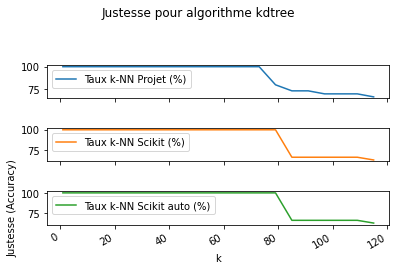

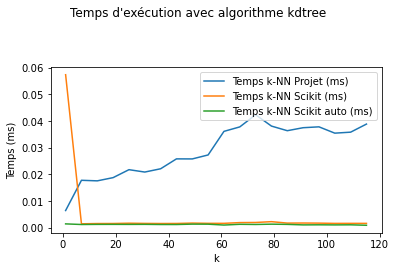

,k,Taux k-NN Projet (%),Taux k-NN Scikit (%),Taux k-NN Scikit auto (%),Temps k-NN Projet (ms),Temps k-NN Scikit (ms),Temps k-NN Scikit auto (ms)
0,1,69.444444,72.222222,72.222222,0.013566,0.002222,0.001571
1,8,77.777778,83.333333,83.333333,0.016289,0.001611,0.001316
2,15,80.555556,83.333333,83.333333,0.018398,0.001488,0.001219
3,22,72.222222,86.111111,86.111111,0.020859,0.001403,0.001152
4,29,77.777778,86.111111,86.111111,0.024430,0.001396,0.001570
5,36,86.111111,86.111111,86.111111,0.027727,0.001492,0.001136
6,43,83.333333,86.111111,86.111111,0.031794,0.001471,0.001152
7,50,80.555556,80.555556,80.555556,0.030600,0.001614,0.001126
8,57,83.333333,83.333333,83.333333,0.032560,0.001461,0.001114
9,64,80.555556,80.555556,80.555556,0.034286,0.001468,0.001076


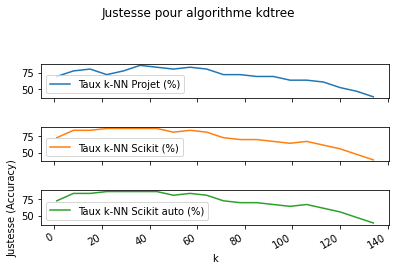

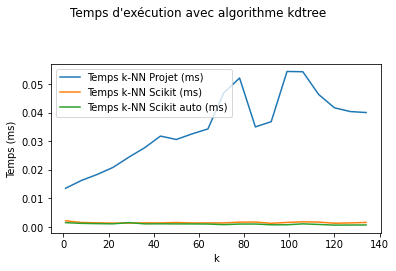

,k,Taux k-NN Projet (%),Taux k-NN Scikit (%),Taux k-NN Scikit auto (%),Temps k-NN Projet (ms),Temps k-NN Scikit (ms),Temps k-NN Scikit auto (ms)
0,1,44.0,49.5,48.5,0.128644,0.007107,0.004331
1,41,57.5,60.5,61.5,0.644613,0.004725,0.004014
2,81,60.5,58.5,58.5,0.962256,0.003950,0.003310
3,121,59.0,58.5,58.5,1.172019,0.003996,0.003339
4,161,58.5,58.5,58.5,1.516231,0.005017,0.003955
5,201,58.5,58.5,58.5,1.884038,0.005158,0.004215
6,241,58.5,58.5,58.5,1.900784,0.005556,0.004625
7,281,58.5,58.5,58.5,2.245905,0.004730,0.006453
8,321,58.5,58.5,58.5,2.088447,0.005500,0.004128
9,361,58.5,58.5,58.5,2.342654,0.005298,0.003935


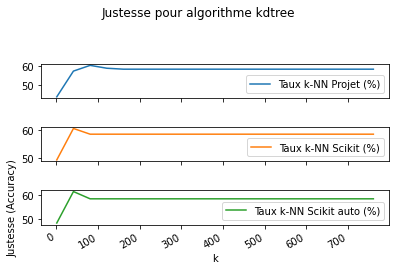

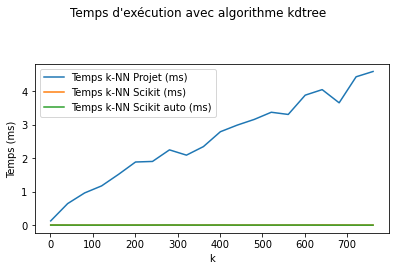

In [16]:
for dataset_name, data in all_datasets.items():
    # trouver random_state value pour chaque dataset
    x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.2, random_state=0, stratify=data[1])
    
    sklearn_exec_time = []
    sklearn_auto_exec_time = []
    projet_exec_time = []
    
    sklearn_score = []
    sklearn_auto_score = []
    projet_score = []
    
    if len(x_train) % 20 == 0:
        k_list = range(1, len(x_train), int(len(x_train) / 20))
    else: 
        reste = len(x_train) % 20
        k_list = range(1, len(x_train) - reste, int(len(x_train) / 20))
            
    for k in k_list:
        # sklearn : kdtree
        start_time_sklearn = timeit.default_timer()
        sklearn_result = sklearn_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_sklearn = (timeit.default_timer() - start_time_sklearn)
        #print("knn kdtree sklearn avec k = "+str(k)+": --- %s seconds ---" % (time_execution_sklearn))
        
        score_sklearn = sklearn_result.score(x_test, y_test) * 100

        sklearn_exec_time.append(time_execution_sklearn)
        sklearn_score.append(score_sklearn)
        
        
        
        # sklearn : auto
        start_time_sklearn_auto = timeit.default_timer()
        sklearn_auto_result = sklearn_knn_auto(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_sklearn_auto = (timeit.default_timer() - start_time_sklearn_auto)
        #print("knn auto sklearn avec k = "+str(k)+": --- %s seconds ---" % (time_execution_sklearn_auto))
        
        score_sklearn_auto = sklearn_auto_result.score(x_test, y_test) * 100

        sklearn_auto_exec_time.append(time_execution_sklearn_auto)
        sklearn_auto_score.append(score_sklearn_auto)       
        
        
        #projet
        start_time_projet = timeit.default_timer()
        projet_result = projet_knn_kdtree(x_train, x_test, y_train, y_test, nb_neighbors=k)
        time_execution_projet = (timeit.default_timer() - start_time_projet)
        #print("knn kdtree projet avec k = "+str(k)+": --- %s seconds ---" % (time_execution_projet))
        
        score_project = calculate_accuracy(projet_result, y_test) * 100

        projet_exec_time.append(time_execution_projet)
        projet_score.append(score_project)
    
    
    df = pd.DataFrame({'k': k_list,
                       'Taux k-NN Projet (%)': projet_score,
                       'Taux k-NN Scikit (%)': sklearn_score,
                       'Taux k-NN Scikit auto (%)': sklearn_auto_score,
                       'Temps k-NN Projet (ms)': projet_exec_time,
                       'Temps k-NN Scikit (ms)': sklearn_exec_time,
                       'Temps k-NN Scikit auto (ms)': sklearn_auto_exec_time
                       
                      })
    display(df)

        #Justess
    df.plot.line(x="k", y=['Taux k-NN Projet (%)','Taux k-NN Scikit (%)','Taux k-NN Scikit auto (%)'], subplots=True) #subplots =graphiques séparés par série
    plt.suptitle('Justesse pour algorithme kdtree')
    plt.xlabel('k')
    plt.ylabel('Justesse (Accuracy)')
    plt.tight_layout(pad=2.5) # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.
    plt.show()

    #Temps d'execution  
    df.plot.line(x="k", y=['Temps k-NN Projet (ms)', 'Temps k-NN Scikit (ms)', 'Temps k-NN Scikit auto (ms)'], subplots=False)
    plt.suptitle("Temps d'exécution avec algorithme kdtree")
    plt.xlabel('k')
    plt.ylabel('Temps (ms)')
    plt.tight_layout(pad=2.5)
    plt.show()






En premier lieu nous remarquons que le temps d'éxecution est beaucoup moins important lorsque nous utilisons la bibliothèque Sckit Learn. Lorsque nous utilisons l'algorithme automatique comparé à l'algorithme kd tree, nous pouvons avoir des piques montrant que l'éxecution prend légèrement plus de temps. 
Quant au taux de chaque jeu de données, quelque soit la méthode, ce taux se ressemble en général. Même si le taux peut avoir un nombre différent, la tendance de la courbe reste la même. 

Intéressant nous à estimer la valeur de k, en évitant le risque de surapprentissage et de sous-apprentissage, ainsi qu'à la justesse de prédiction. 

    - Iris :
Avec ce jeu de données, nous remarquons que le taux de nombre de prédictions correctes est maximale jusqu'à que k vaut 76. De ce fait, nous pouvons déterminer que k = 76.

    - Wine
Quant à ce jeu de données, nous constatons que la justesse de prédiction n'est jamais à 100%. Cependant, elle reste assez forte et lorsque k vaut 46, de dernier maximise la justesse. Donc k = 46.

    - Forest
Pour finir, avec ce jeu de données on remarque que le nombre de prédictions correctes est très faible, quelque soit l'algorithme utilisé. De plus, la tendance des coubres représentant le taux sont semblables entre les algorithmes de python et celui de notre projet. Mais nous ne pouvons pas détermier précisément le k le plus optimal. On peut tout de même conclure qu'il serait entre 40 et 90. Mais plus problablement un k plus proche de 40 si on se fit aux algorithmes de python. 

In [17]:
    
'''
    
        #Justess
    df.plot.line(x="k", y=['Taux k-NN Projet (%)','Taux k-NN Scikit (%)'], subplots=True) #subplots =graphiques séparés par série
    plt.suptitle('Justesse pour algorithme kdtree')
    plt.xlabel('k')
    plt.ylabel('Justesse (Accuracy)')
    plt.tight_layout(pad=2.5) # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.
    plt.show()

    #Temps d'execution  
    df.plot.line(x="k", y=['Temps k-NN Projet (ms)', 'Temps k-NN Scikit (ms)'], subplots=False)
    plt.suptitle("Temps d'exécution avec algorithme kdtree")
    plt.xlabel('k')
    plt.ylabel('Temps (ms)')
    plt.tight_layout(pad=2.5)
    plt.show()
    
    
         #Justess
    df.plot.line(x="k", y=['Taux k-NN Projet (%)','Taux k-NN Scikit auto (%)'], subplots=True) #subplots =graphiques séparés par série
    plt.suptitle('Justesse pour algorithme automatique')
    plt.xlabel('k')
    plt.ylabel('Justesse (Accuracy)')
    plt.tight_layout(pad=2.5) # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.
    plt.show()
    
    #Temps d'execution  
    df.plot.line(x="k", y=['Temps k-NN Projet (ms)', 'Temps k-NN Scikit auto (ms)'], subplots=False)
    plt.suptitle("Temps d'exécution pour algorithme automatique")
    plt.xlabel('k')
    plt.ylabel('Temps (ms)')
    plt.tight_layout(pad=2.5)
    plt.show()

'''

'\n    \n        #Justess\n    df.plot.line(x="k", y=[\'Taux k-NN Projet (%)\',\'Taux k-NN Scikit (%)\'], subplots=True) #subplots =graphiques séparés par série\n    plt.suptitle(\'Justesse pour algorithme kdtree\')\n    plt.xlabel(\'k\')\n    plt.ylabel(\'Justesse (Accuracy)\')\n    plt.tight_layout(pad=2.5) # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.\n    plt.show()\n\n    #Temps d\'execution  \n    df.plot.line(x="k", y=[\'Temps k-NN Projet (ms)\', \'Temps k-NN Scikit (ms)\'], subplots=False)\n    plt.suptitle("Temps d\'exécution avec algorithme kdtree")\n    plt.xlabel(\'k\')\n    plt.ylabel(\'Temps (ms)\')\n    plt.tight_layout(pad=2.5)\n    plt.show()\n    \n    \n         #Justess\n    df.plot.line(x="k", y=[\'Taux k-NN Projet (%)\',\'Taux k-NN Scikit auto (%)\'], subplots=True) #subplots =graphiques séparés par série\n    plt.suptitle(\'Justesse pour algorithme automatique\')\n    plt.xlabel(\'k\')\n    plt.ylabel(\'Ju